# Import des librairies

In [2]:
import pandas as pd
import sys
sys.path.append('..')
from scripts.Cleaning import Featurescleaning
from scripts.RecommandationSystem import RecommandationSystem
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.neighbors import KNeighborsRegressor, NearestNeighbors
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_val_score
from sklearn.metrics.pairwise import cosine_similarity


# Récupération des données avec features et pré-nettoyage

In [ ]:
df = pd.read_csv(filepath_or_buffer='../data/all_data_for_10000_lines.csv')
df = Featurescleaning(df)
df

,tconst,titletype,primarytitle,isadult,startyear,genres,averagerating,numvotes,seasonnumber,episodenumber,regionnumber,regionlist,actor,self,producer,actress,director,weighted_score
0,tt12826552,short,Grave of mammals and the interlopers,False,2026,"Documentary,Family,Mystery",NaN,NaN,NaN,NaN,2.0,[IN],[],[],[],[],[Hyash Tanmoy],7.521666
1,tt13163296,movie,The Reunion,False,2026,Thriller,NaN,NaN,NaN,NaN,2.0,[US],[],[],[],[],[Grace Wan],7.521666
2,tt13294590,movie,Skyscraper on an Uninhabited Island,False,2026,"Adventure,Drama,Sci-Fi",NaN,NaN,NaN,NaN,2.0,[US],[],[],[],[],[Leonid Khromov],7.521666
3,tt13666744,videoGame,Prince of Persia: The Sands of Time,False,2026,"Action,Adventure,Fantasy",NaN,NaN,NaN,NaN,3.0,"[XWW, US, XWW, US]",[],[],[],[],[],7.521666
4,tt14478286,tvSeries,Untitled Liver Bird Films Project,False,2026,Drama,NaN,NaN,1.0,1.0,2.0,[GB],[],[],[],[],[],7.521666
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,tt8579706,tvEpisode,The Final Deduction,False,2029,Drama,NaN,NaN,1.0,6.0,1.0,[],"[George Stackhouse, Matthew Leeson, Aaron Murr...",[],[],"[Eve Harding, Lauren Barratt, Katie Amanda Smi...",[Aisleen Hodges],7.521666
9996,tt8814476,movie,Supergirl: Woman of Tomorrow,False,2026,"Action,Adventure,Fantasy",NaN,NaN,NaN,NaN,5.0,"[GB, IN, CA, US, CA]",[],[],[James Gunn],"[Milly Alcock, Milly Alcock]",[Craig Gillespie],7.521666
9997,tt9077514,movie,Untitled the Chronicles of Narnia Netflix Film,False,2026,"Adventure,Family,Fantasy",NaN,NaN,NaN,NaN,2.0,[US],[],[],[Amy Pascal],[],[Greta Gerwig],7.521666
9998,tt9173310,tvSeries,Men of Gray - The Flying Squad,False,2026,Action,NaN,NaN,NaN,NaN,2.0,[TT],[],[],[],[],[],7.521666


# Préparation de la pipeline pour la prédiction de la popularité

## Séparation en features et target

In [3]:
features = df.drop(columns=["averagerating", "numvotes", "weighted_score", "tconst", "primarytitle", "self", "director", "producer"])
features

,titletype,isadult,startyear,genres,seasonnumber,episodenumber,regionnumber,regionlist,actor,actress
0,short,False,2026,"Documentary,Family,Mystery",NaN,NaN,2.0,[IN],[],[]
1,movie,False,2026,Thriller,NaN,NaN,2.0,[US],[],[]
2,movie,False,2026,"Adventure,Drama,Sci-Fi",NaN,NaN,2.0,[US],[],[]
3,videoGame,False,2026,"Action,Adventure,Fantasy",NaN,NaN,3.0,"[XWW, US, XWW, US]",[],[]
4,tvSeries,False,2026,Drama,1.0,1.0,2.0,[GB],[],[]
...,...,...,...,...,...,...,...,...,...,...
9995,tvEpisode,False,2029,Drama,1.0,6.0,1.0,[],"[George Stackhouse, Matthew Leeson, Aaron Murr...","[Eve Harding, Lauren Barratt, Katie Amanda Smi..."
9996,movie,False,2026,"Action,Adventure,Fantasy",NaN,NaN,5.0,"[GB, IN, CA, US, CA]",[],"[Milly Alcock, Milly Alcock]"
9997,movie,False,2026,"Adventure,Family,Fantasy",NaN,NaN,2.0,[US],[],[]
9998,tvSeries,False,2026,Action,NaN,NaN,2.0,[TT],[],[]


In [4]:
features.rename(columns={"self": "selfperson"}, inplace=True)

In [115]:
target = df[["weighted_score"]].fillna(0)
target

,weighted_score
0,7.521666
1,7.521666
2,7.521666
3,7.521666
4,7.521666
...,...
9995,7.521666
9996,7.521666
9997,7.521666
9998,7.521666


On garde 20% de test:

In [116]:
features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=0.2, random_state=42)

## Création de la pipeline

pour choisir les preprocessing: 

In [117]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 18 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   tconst          10000 non-null  object 
 1   titletype       10000 non-null  object 
 2   primarytitle    10000 non-null  object 
 3   isadult         10000 non-null  bool   
 4   startyear       10000 non-null  int64  
 5   genres          10000 non-null  object 
 6   averagerating   603 non-null    float64
 7   numvotes        603 non-null    float64
 8   seasonnumber    6075 non-null   float64
 9   episodenumber   6075 non-null   float64
 10  regionnumber    4679 non-null   float64
 11  regionlist      10000 non-null  object 
 12  actor           10000 non-null  object 
 13  self            10000 non-null  object 
 14  producer        10000 non-null  object 
 15  actress         10000 non-null  object 
 16  director        10000 non-null  object 
 17  weighted_score  10000 non-null  

On effectue différents preprocessing et encoding selon les features:

- valeurs numériques: imputation ? normalisation ? 
  - startyear 73% rempli -> on enlève les non rempli ou on impute ?
  - endyear presque non rempli -> on enlève la colonne 
  - runtimeminutes 23% rempli -> on enlève la colonne
  - seasonnumber et episodenumber 66% rempli : ceux qui n'en ont pas ne sont pas des séries -> imputation par 1
- primarytitle: tfidvectorizer
- titletype: ordinalencoder
- genres, actor, actress, self, producer, director, regionlist: multilabelbinarizer

In [118]:
features

,titletype,isadult,startyear,genres,seasonnumber,episodenumber,regionnumber,regionlist,actor,actress
0,short,False,2026,"Documentary,Family,Mystery",NaN,NaN,2.0,[IN],[],[]
1,movie,False,2026,Thriller,NaN,NaN,2.0,[US],[],[]
2,movie,False,2026,"Adventure,Drama,Sci-Fi",NaN,NaN,2.0,[US],[],[]
3,videoGame,False,2026,"Action,Adventure,Fantasy",NaN,NaN,3.0,"[XWW, US, XWW, US]",[],[]
4,tvSeries,False,2026,Drama,1.0,1.0,2.0,[GB],[],[]
...,...,...,...,...,...,...,...,...,...,...
9995,tvEpisode,False,2029,Drama,1.0,6.0,1.0,[],"[George Stackhouse, Matthew Leeson, Aaron Murr...","[Eve Harding, Lauren Barratt, Katie Amanda Smi..."
9996,movie,False,2026,"Action,Adventure,Fantasy",NaN,NaN,5.0,"[GB, IN, CA, US, CA]",[],"[Milly Alcock, Milly Alcock]"
9997,movie,False,2026,"Adventure,Family,Fantasy",NaN,NaN,2.0,[US],[],[]
9998,tvSeries,False,2026,Action,NaN,NaN,2.0,[TT],[],[]


On définit les étapes de chaque branches

In [119]:
# Définir les pipelines
yearPipeline = Pipeline(steps=[("inputing", SimpleImputer(strategy="median")), ("scaling", StandardScaler())])
seasonEpisodeNumberPipeline = Pipeline(steps=[("inputing", SimpleImputer(strategy="constant", fill_value=1)), ("scaling", StandardScaler())])
primarytitlePipeline = Pipeline(steps=[("tfidf", TfidfVectorizer(stop_words="english"))])
titletypePipeline = Pipeline(steps=[("tfidf", OrdinalEncoder())])
genresPipeline = Pipeline(steps=[
    ('binarizer', CountVectorizer(analyzer=lambda x: set(x)))
])
actorPipeline = Pipeline(steps=[
        ('binarizer', CountVectorizer(analyzer=lambda x: set(x)))
])
actressPipeline = Pipeline(steps=[
        ('binarizer', CountVectorizer(analyzer=lambda x: set(x)))
])
selfPipeline = Pipeline(steps=[
    ('binarizer', CountVectorizer(analyzer=lambda x: set(x)))
])
producerPipeline = Pipeline(steps=[
        ('binarizer', CountVectorizer(analyzer=lambda x: set(x)))
])
directorPipeline = Pipeline(steps=[
        ('binarizer', CountVectorizer(analyzer=lambda x: set(x)))
])

On crée toutes les branches

In [120]:
preprocessing = ColumnTransformer(transformers=[
    ("year", yearPipeline, ["startyear"]),
    ("seasonEpisodeNumber", seasonEpisodeNumberPipeline, ["seasonnumber", "episodenumber"]),
    # ("primarytitle", primarytitlePipeline, "primarytitle"),
    ("titletype", titletypePipeline, ["titletype"]),
    ("genres", genresPipeline, "genres"),
    ("actor", actorPipeline, "actor"),
    # ("selfperson", selfPipeline, "selfperson"),
    ("actress", actressPipeline, "actress"),
    # ("producer", producerPipeline, "producer"),
    # ("director", directorPipeline, "director")
])

On Finaliser la pipeline avec le modèle

In [188]:
modelPipe = Pipeline(steps=[
    ("prep données", preprocessing),
    ("model", KNeighborsRegressor())
])

On entraine le modèle

In [189]:

# features["selfperson"] = features_train["selfperson"].apply(lambda x: ' '.join(x))

modelPipe.fit(features_train, target_train)

Pipeline(steps=[('prep données',
                 ColumnTransformer(transformers=[('year',
                                                  Pipeline(steps=[('inputing',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaling',
                                                                   StandardScaler())]),
                                                  ['startyear']),
                                                 ('seasonEpisodeNumber',
                                                  Pipeline(steps=[('inputing',
                                                                   SimpleImputer(fill_value=1,
                                                                                 strategy='constant')),
                                                                  ('scaling',
                                                                   StandardScaler())]),
                                                  ['seasonnumber',
                                                   'episodenumber']),
                                                 ('titl...
                                                  Pipeline(steps=[('binarizer',
                                                                   CountVectorizer(analyzer=<function <lambda> at 0x0000017967337C40>))]),
                                                  'genres'),
                                                 ('actor',
                                                  Pipeline(steps=[('binarizer',
                                                                   CountVectorizer(analyzer=<function <lambda> at 0x0000017967337740>))]),
                                                  'actor'),
                                                 ('actress',
                                                  Pipeline(steps=[('binarizer',
                                                                   CountVectorizer(analyzer=<function <lambda> at 0x0000017967337BA0>))]),
                                                  'actress')])),
                ('model', KNeighborsRegressor())])

On évalue le modèle

In [190]:
predict = modelPipe.predict(features_test)
predict

array([[7.52166573],
       [7.52166573],
       [7.52968033],
       ...,
       [7.52166573],
       [7.52166573],
       [7.52166573]], shape=(2000, 1))

In [191]:
mse = mean_squared_error(target_test, predict)
mae = mean_absolute_error(target_test, predict)
r2 = r2_score(target_test, predict)

print(f"Mean Squared Error (MSE): {mse}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"RMSE: {mse**0.5}")
print(f"R-squared (R2): {r2}")

Mean Squared Error (MSE): 0.0003303094752032871
Mean Absolute Error (MAE): 0.0031624069927500154
RMSE: 0.018174418153087794
R-squared (R2): 0.3244275528968603


In [192]:
scores = cross_val_score(modelPipe, features, target, cv=5, scoring='r2')
print(f"R² moyen avec validation croisée : {scores.mean()}")
print(f"Écart-type des scores R² : {scores.std()}")

R² moyen avec validation croisée : -3.8116805914956062
Écart-type des scores R² : 3.5108747669225027


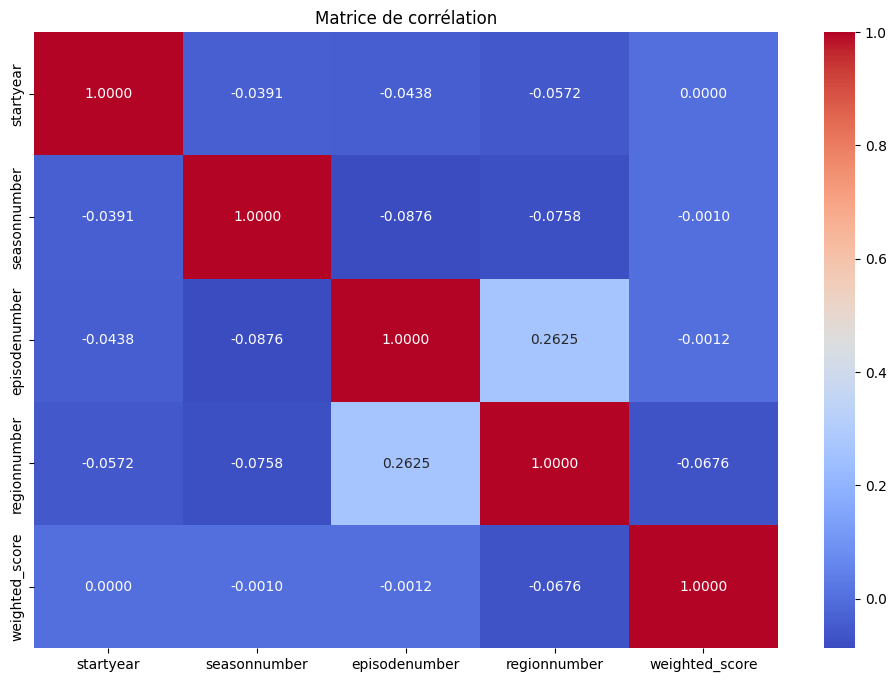

In [193]:
import seaborn as sns

import matplotlib.pyplot as plt

modelPipePrep = Pipeline(steps=[
    ("prep données", preprocessing)
])
prepfeatures = modelPipePrep.fit_transform(features)

numeric_df = features.select_dtypes(include=[float, int])
numeric_df = pd.concat([numeric_df, target], axis=1)

correlation_matrix = numeric_df.corr()
# Affichage de la matrice de corrélation
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.4f')
plt.title('Matrice de corrélation')
plt.show()

## Test de la classe du modèle

In [7]:
import sys
sys.path.append('..')
from scripts.PopularitySystem import PopularityPrediction
from scripts.Cleaning import Featurescleaning
import pandas as pd

In [8]:
df = Featurescleaning(pd.read_csv(filepath_or_buffer='../data/all_data_for_10000_lines.csv'))


In [11]:
model = PopularityPrediction()

In [12]:
model.fit(df)

In [14]:
model.evaluate()

MSE:  0.00033924926706496234
MAE:  0.00324172635832492
R2:  0.30614325432847156


In [16]:
model.predict(df)

array([[7.52166573],
       [7.52166573],
       [7.52166573],
       ...,
       [7.52166573],
       [7.52166573],
       [7.52166573]])

# Préparation de la recommandation de films

## Avec Cosine Similarity

On prépare les features de la même manière que pour la prédiction de popularité et on créer la matrice de similarité avec cosine similarity.

In [194]:

modelPipeReco = Pipeline(steps=[
    ("prep données", preprocessing)
])

features_transformed = modelPipeReco.fit_transform(features)

cosine_sim = cosine_similarity(features_transformed)

cosine_sim

array([[1.        , 0.64801822, 0.79358196, ..., 0.84752215, 0.57973134,
        0.7571913 ],
       [0.64801822, 1.        , 0.61000164, ..., 0.6733143 , 0.41103987,
        0.84616901],
       [0.79358196, 0.61000164, 1.        , ..., 0.86358919, 0.43630006,
        0.68641874],
       ...,
       [0.84752215, 0.6733143 , 0.86358919, ..., 1.        , 0.41340438,
        0.69994452],
       [0.57973134, 0.41103987, 0.43630006, ..., 0.41340438, 1.        ,
        0.38215425],
       [0.7571913 , 0.84616901, 0.68641874, ..., 0.69994452, 0.38215425,
        1.        ]], shape=(10000, 10000))

On choisir un nom de film.

In [195]:
df["primarytitle"].to_list()

['Grave of mammals and the interlopers',
 'The Reunion',
 'Skyscraper on an Uninhabited Island',
 'Prince of Persia: The Sands of Time',
 'Untitled Liver Bird Films Project',
 "Ci sono anch'io",
 'Untitled Steven Spielberg´s Event Film Amblin Universal',
 'Destitute',
 'Trounce',
 "No Wonder You're Single",
 'Episode #1.1',
 'A Weekend in Busan',
 'Maroon by Day',
 'Scarlet',
 'Welcome to the Kyriarchy',
 'Make New Friends But Keep the Old',
 'Interreligious Dialogue',
 'Do You Wanna Be Friends?',
 'The Story of Jovan',
 'The Story of Mui',
 'Francophoney',
 'Sonic the Hedgehog 4',
 "Don't @ Me",
 'Episode #3.1',
 'Aang: The Last Airbender',
 'The Dark Dinosaur Movie: Darkness of the Multiverse',
 'Underverse 0.8 Part 2',
 'Underverse 0.9',
 'Underverse 1.0',
 'Milo and Aurora',
 'Peachtree One',
 'The Batman Part II',
 'National Memorial Day Concert',
 'A Capitol Fourth',
 "'Teddy' for sale",
 '#HypernovaBabe',
 'Transylvania',
 'G.R.I.M.E. (1g)',
 '56 Notthing Hill Drive',
 'Granny, 

On récupère le films dans la base si il est présent.

In [196]:
film = "The Reunion"
if film not in df["primarytitle"].values:
    raise ValueError(f"Le film '{film}' n'est pas présent dans la colonne 'primarytitle'.")

On récupère le films, puis la ligne qui le concerne dans la matrice, et on trie la ligne selon la score de similarité pour récupérer les 5 plus haut (autre que lui même), puis on les affichent.

In [197]:
if film not in df["primarytitle"].values:
    raise ValueError(f"Le film '{film}' n'est pas présent dans la colonne 'primarytitle'.")
index = df[df["primarytitle"] == film].index[0]
cosine_similarities = cosine_sim[index]
similar_indices = cosine_similarities.argsort()[::-1][1:6]
similar_movies = df.iloc[similar_indices]
similar_movies

,tconst,titletype,primarytitle,isadult,startyear,genres,averagerating,numvotes,seasonnumber,episodenumber,regionnumber,regionlist,actor,self,producer,actress,director,weighted_score
1,tt13163296,movie,The Reunion,False,2026,Thriller,NaN,NaN,NaN,NaN,2.0,[US],[],[],[],[],[Grace Wan],7.521666
9980,tt6475412,movie,Krrish 4,False,2026,Thriller,NaN,NaN,NaN,NaN,8.0,"[AU, CA, DE, GB, IN, US, RU]",[],[],[],[],[],7.521666
1230,tt33550089,movie,Ghost Date,False,2026,"Horror,Thriller",NaN,NaN,NaN,NaN,2.0,[US],[],[],[Maximiliano Czertok],[],[Erik Bernard],7.521666
212,tt32141377,movie,28 Years Later: The Bone Temple,False,2026,"Horror,Thriller",NaN,NaN,NaN,NaN,3.0,"[CA, US]",[],[],[],[],[],7.521666
231,tt32528755,movie,Nightmares,False,2026,"Drama,Thriller",NaN,NaN,NaN,NaN,2.0,[US],[],[],[],[],[],7.521666


## Test de la fonction

In [4]:
df = pd.read_csv('../data/all_data_for_10000_lines.csv')
movies = RecommandationSystem(df, "The Reunion")
movies

,tconst,titletype,primarytitle,isadult,startyear,genres,averagerating,numvotes,seasonnumber,episodenumber,regionnumber,regionlist,actor,self,producer,actress,director,weighted_score
1,tt13163296,movie,The Reunion,False,2026,Thriller,NaN,NaN,NaN,NaN,2.0,[US],[],[],[],[],[Grace Wan],7.521666
9980,tt6475412,movie,Krrish 4,False,2026,Thriller,NaN,NaN,NaN,NaN,8.0,"[AU, CA, DE, GB, IN, US, RU]",[],[],[],[],[],7.521666
1230,tt33550089,movie,Ghost Date,False,2026,"Horror,Thriller",NaN,NaN,NaN,NaN,2.0,[US],[],[],[Maximiliano Czertok],[],[Erik Bernard],7.521666
212,tt32141377,movie,28 Years Later: The Bone Temple,False,2026,"Horror,Thriller",NaN,NaN,NaN,NaN,3.0,"[CA, US]",[],[],[],[],[],7.521666
231,tt32528755,movie,Nightmares,False,2026,"Drama,Thriller",NaN,NaN,NaN,NaN,2.0,[US],[],[],[],[],[],7.521666


## Avec les plus proches voisins

In [200]:


modelPipeReco = Pipeline(steps=[
    ("prep données", preprocessing),
    ("knn", NearestNeighbors(n_neighbors=6))
])

In [201]:
modelPipeReco.fit(features)

Pipeline(steps=[('prep données',
                 ColumnTransformer(transformers=[('year',
                                                  Pipeline(steps=[('inputing',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaling',
                                                                   StandardScaler())]),
                                                  ['startyear']),
                                                 ('seasonEpisodeNumber',
                                                  Pipeline(steps=[('inputing',
                                                                   SimpleImputer(fill_value=1,
                                                                                 strategy='constant')),
                                                                  ('scaling',
                                                                   StandardScaler())]),
                                                  ['seasonnumber',
                                                   'episodenumber']),
                                                 ('titl...
                                                                   CountVectorizer(analyzer=<function <lambda> at 0x0000017967337C40>))]),
                                                  'genres'),
                                                 ('actor',
                                                  Pipeline(steps=[('binarizer',
                                                                   CountVectorizer(analyzer=<function <lambda> at 0x0000017967337740>))]),
                                                  'actor'),
                                                 ('actress',
                                                  Pipeline(steps=[('binarizer',
                                                                   CountVectorizer(analyzer=<function <lambda> at 0x0000017967337BA0>))]),
                                                  'actress')])),
                ('knn', NearestNeighbors(n_neighbors=6))])